# Chained deep learning using generalized cross entropy for multiple annotators segmentation



## Loss functions for segmentation in deep learning


Given a $k$ class multiple annotators segmentation problem with a dataset like the following'

$$\mathbf X \in \mathbb{R}^{W \times H}, \{ \mathbf Y_r \in \{0,1\}^{W \times H \times K} \}_{r=1}^R; \;\; \mathbf {\hat Y} \in [0,1]^{W\times H \times K} = f(\mathbf X)$$

The segmentation mask function will map input output as follows:

$$f: \mathbb  R ^{W\times H} \to [0,1]^{W\times H\times K}$$

$\mathbf Y$ will satisfy the following condition for being a softmax-like representation:

$$\mathbf Y_r[w,h,:] \mathbf{1} ^ \top _ k = 1; \;\; w \in W, h \in H$$

Now, let's suppose the existence of an annotators reliability map estimation $\Lambda_r; \; r \in R$;


$$\bigg\{ \Lambda_r (\mathbf X; \theta ) \in [0,1] ^{W\times H} \bigg\}_{r=1}^R$$

Then, our $TGCE_{SS}$:


$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \mathbf{\Lambda}_r (\mathbf X;\theta)) =\mathbb E_{r} \left\{ \mathbb E_{w,h} \left\{ \Lambda_r (\mathbf X; \theta) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \Lambda _r (\mathbf X;\theta)\right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$


Where $q \in (0,1)$

Total Loss for a given batch holding $N$ samples:

$$\mathscr{L}\left(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta)\right)  = \frac{1}{N} \sum_{n}^NTGCE_{SS}(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta))$$

In [1]:
%%capture
!pip install -U git+https://github.com/UN-GCPDS/python-gcpds.image_segmentation.git >> /tmp/null
!pip install wandb
!pip install keras

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


import random
import warnings
import cv2

from functools import partial
from enum import auto, Enum

import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn.manifold import TSNE

from gcpds.image_segmentation.datasets.segmentation import OxfordIiitPet
from gcpds.image_segmentation.visualizations import plot_contour
from gcpds.image_segmentation.models import unet_baseline
from tensorflow.keras.metrics import Metric
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.backend as K
from keras.layers import Layer


from matplotlib.style import available
import tensorflow as tf
from tensorflow.keras.losses import Loss
from tensorflow.keras import Model, layers, regularizers
# Custom activation function
from keras.layers import Activation

import matplotlib.pyplot as plt
import os
import numpy as np
import gc
from datetime import datetime
from tensorflow.python.framework.ops import EagerTensor

import wandb
from wandb.keras import WandbCallback

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
dataset = OxfordIiitPet()
train_dataset, val_dataset, test_dataset = dataset()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZREQIC/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteZREQIC/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [11]:
model_url = "https://drive.google.com/file/d/1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G/view?usp=drive_link"
model_uri = model_url.split("/")[5]
!gdown $model_uri

Downloading...
From: https://drive.google.com/uc?id=1x39L3QNDMye1SJhKh1gf4YS-HRFLTs6G
To: /kaggle/working/oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice0.826.keras
100%|██████████████████████████████████████| 6.24M/6.24M [00:00<00:00, 57.7MB/s]


In [12]:
model_extension = "keras"
paths = []

for file in os.listdir("."):
  if file.endswith(model_extension):
    paths.append(file)

model_path = paths[0]
print(f"Loading {model_path}...")
model_ann  = tf.keras.models.load_model(model_path, compile = False)

Loading oxford_pet_model_no_border2023-08-28 04 42 29.425657_dice0.826.keras...


In [13]:
def find_last_encoder_conv_layer(model):
  last_conv_encoder_layer = 0
  for i,layer in enumerate(model.layers):
    if (isinstance(layer, keras.layers.Conv2D)):
      last_conv_encoder_layer = i
    if (isinstance(layer, keras.layers.UpSampling2D)):
      break
  return last_conv_encoder_layer

last_conv_encoder_layer = find_last_encoder_conv_layer(model_ann)
last_conv_encoder_layer

24

In [14]:
def compute_snr(signal:float, noise_std:float)->float:
  return  10 * np.log10(np.mean(signal ** 2)  / noise_std ** 2)

class SnrType(Enum):
  log = 0
  linear = 1


def add_noise_to_layer_weights(model, layer, noise_snr, snr_type: SnrType = SnrType.log, verbose = 0):
  layer_weights = model.layers[layer].get_weights()

  sig_power = np.mean(layer_weights[0] ** 2)


  if snr_type == SnrType.log:
    noise_power = sig_power / (10 ** (noise_snr / 10) )
  elif snr_type == SnrType.linear:
    noise_power = sig_power / noise_snr

  noise_std = noise_power ** ( 1 / 2)

  snr = compute_snr(layer_weights[0], noise_std)


  if verbose > 0 :
    print(f"Adding noise for snr: {noise_snr}\n\n")
    print(f"Signal power: {sig_power}")
    print(f"Noise power: {noise_power}\n\n")

  for i in range(layer_weights[0].shape[0]):
    for j in range(layer_weights[0].shape[1]):
      layer_weights[0][i][j] += np.random.randn(128,128) * noise_std

  model.layers[last_conv_encoder_layer].set_weights(layer_weights)
  return snr

In [15]:
values_to_test = [-10, -2, -5, 10, -12]


def produce_disturbed_models(values_to_test, base_model_path):
  snr_values = []
  models = []

  for value in values_to_test:
    model_ = tf.keras.models.load_model(base_model_path, compile = False)
    snr = add_noise_to_layer_weights(model_, last_conv_encoder_layer, value)
    snr_values.append(snr)
    models.append(model_)
  return models, snr_values

disturbance_models, snr_values = produce_disturbed_models(values_to_test, model_path)

In [16]:
disturbance_models[0].output

<KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'Conv100')>

In [17]:
BATCH_SIZE = 32
NUM_EPOCHS = 50
TARGET_SHAPE = 256, 256
ANNOTATORS = 5

def disturb_mask(model, image):
  return model(image)


def mix_channels(mask, num_annotators):
  return tf.stack([mask, 1-mask], axis=-2)

def add_noisy_annotators(img: EagerTensor, models)->EagerTensor:
  return tf.transpose([disturb_mask(model, img) for model in models], [2,3,1,4,0])


def map_dataset_MA(dataset, target_shape, batch_size, num_annotators):
    dataset_ = dataset.map(lambda img,mask,label,id_img: (img,mask),
                                      num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (tf.image.resize(img,target_shape), tf.image.resize(mask,target_shape)),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (tf.image.resize(img,target_shape), tf.image.resize(mask,target_shape)),
                                    num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, add_noisy_annotators(tf.expand_dims(img, 0), disturbance_models)),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, tf.reshape(mask, (mask.shape[0], mask.shape[1], 1, mask.shape[-1] ))),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, mix_channels(mask, num_annotators)),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.map(lambda img,mask: (img, tf.squeeze(mask, axis=2 )),
                           num_parallel_calls=tf.data.AUTOTUNE)

    dataset_ = dataset_.batch(batch_size)
    return dataset_


train = map_dataset_MA(train_dataset, TARGET_SHAPE, BATCH_SIZE, ANNOTATORS)
val = map_dataset_MA(val_dataset, TARGET_SHAPE, BATCH_SIZE, ANNOTATORS)
test = map_dataset_MA(test_dataset, TARGET_SHAPE, BATCH_SIZE, ANNOTATORS)

Mask shape: (32, 256, 256, 2, 5) (batch_size * h * w * k * r) Img shape (32, 256, 256, 3)


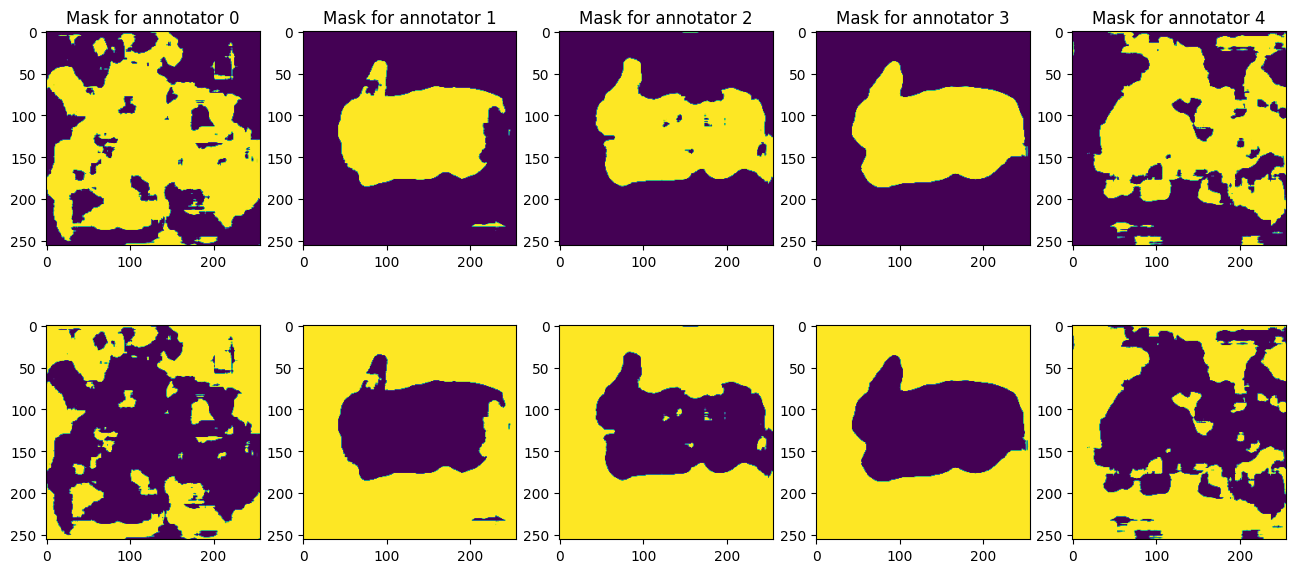

In [18]:
for img,mask in train.take(1):
  print(f"Mask shape: {mask.shape} (batch_size * h * w * k * r) Img shape {img.shape}")
  fig, axes = plt.subplots(2,ANNOTATORS)
  fig.set_size_inches(16,7)
  for i in range(ANNOTATORS):
    axes[0][i].imshow((mask)[0,:,:,0,i])
    axes[0][i].set_title(f"Mask for annotator {i}")
    axes[1][i].imshow((mask)[0,:,:,-1,i])

# Propuesta función de costo Andrés M

# TCGE Loss

Given a $k$ class multiple annotators segmentation problem with a dataset like the following'

$$\mathbf X \in \mathbb{R}^{W \times H}, \{ \mathbf Y_r \in \{0,1\}^{W \times H \times K} \}_{r=1}^R; \;\; \mathbf {\hat Y} \in [0,1]^{W\times H \times K} = f(\mathbf X)$$

The segmentation mask function will map input output as follows:

$$f: \mathbb  R ^{W\times H} \to [0,1]^{W\times H\times K}$$

$\mathbf Y$ will satisfy the following condition for being a softmax-like representation:

$$\mathbf Y_r[w,h,:] \mathbf{1} ^ \top _ k = 1; \;\; w \in W, h \in H$$

Now, let's suppose the existence of an annotators reliability map estimation $\Lambda_r; \; r \in R$;


$$\bigg\{ \Lambda_r (\mathbf X; \theta ) \in [0,1] ^{W\times H} \bigg\}_{r=1}^R$$

Then, our $TGCE_{SS}$:


$$TGCE_{SS}(\mathbf{Y}_r,f(\mathbf X;\theta) | \mathbf{\Lambda}_r (\mathbf X;\theta)) =\mathbb E_{r} \left\{ \mathbb E_{w,h} \left\{ \Lambda_r (\mathbf X; \theta) \circ \mathbb E_k \bigg\{    \mathbf Y_r \circ \bigg( \frac{\mathbf 1 _{W\times H \times K} - f(\mathbf X;\theta) ^{\circ q }}{q} \bigg); k \in K  \bigg\}  + \\ \left(\mathbf 1 _{W \times H } - \Lambda _r (\mathbf X;\theta)\right) \circ \bigg(   \frac{\mathbf 1_{W\times H} - (\frac {1}{k} \mathbf 1_{W\times H})^{\circ q}}{q} \bigg); w \in W, h \in H \right\};r\in R\right\} $$


Where $q \in (0,1)$

Total Loss for a given batch holding $N$ samples:

$$\mathscr{L}\left(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta)\right)  = \frac{1}{N} \sum_{n}^NTGCE_{SS}(\mathbf{Y}_r[n],f(\mathbf X[n];\theta) | \mathbf{\Lambda}_r (\mathbf X[n];\theta))$$

## Clase loss con propuesta AM

In [13]:
class TGCE_SS(Loss):
  def __init__(self, q=0.1, name='TGCE_SS',
               R=5,K_=2,smooth=1e-5,
               **kwargs):
    self.q = q
    self.R = R
    self.K_ = K_
    self.smooth = smooth

    super().__init__(name=name,**kwargs)

  def call(self, y_true, y_pred):
    Lambda_r = y_pred[...,self.K_:] #annotators reilability -> extra cnn upsampling layer
    print(f"Valor mínimo: {tf.reduce_min(y_pred[num_img,:,:,2])} y Valor máximo: {tf.reduce_max(y_pred[num_img,:,:,2])}")
    print(f"Valor mínimo: {tf.reduce_min(y_pred[num_img,:,:,6])} y Valor máximo: {tf.reduce_max(y_pred[num_img,:,:,6])}")
    y_pred_ = y_pred[...,:self.K_] #segmented images from unet
    N,W,H,_ = y_pred_.shape
    y_pred_ = y_pred_[...,tf.newaxis]
    y_pred_ = tf.repeat(y_pred_,repeats=[self.R],axis=-1) #repeat f(x)

    # Ajustes para evitar NaN
    epsilon = 1e-8  # Pequeña constante para evitar divisiones por cero
    y_pred_ = tf.clip_by_value(y_pred_, epsilon, 1.0 - epsilon)  # Limitar valores entre epsilon y 1 - epsilon

    term_r = tf.math.reduce_mean(tf.math.multiply(y_true, (tf.ones([N, W, H, self.K_, self.R]) - tf.pow(y_pred_, self.q)) / (self.q + epsilon + self.smooth)), axis=-2)
    term_c = tf.math.multiply(tf.ones([N, W, H, self.R]) - Lambda_r, (tf.ones([N, W, H, self.R]) - tf.pow((1 / self.K_ + self.smooth) * tf.ones([N, W, H, self.R]), self.q)) / (self.q + epsilon + self.smooth))

    # Evitar NaN en la función de pérdida final
    loss = tf.math.reduce_mean(tf.math.multiply(Lambda_r, term_r) + term_c)
    if tf.math.is_nan(loss):
        loss = tf.where(tf.math.is_nan(loss), tf.constant(0.0), loss) 
    return loss, term_r, term_c


  def get_config(self,):
    base_config = super().get_config()
    return {**base_config, "q": self.q}

In [14]:
class DiceCoefficientMetric(Metric):

    def __init__(self,smooth=1.0, target_class=None, name='DiceCoefficientMetric',**kwargs):
        super().__init__(name=name,**kwargs)
        self.smooth = smooth
        self.target_class = target_class
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")
        

    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.compute(y_true, y_pred)
        self.total.assign_add(tf.reduce_sum(metric))
        self.count.assign_add(tf.cast(tf.shape(y_true)[0], tf.float32))
        
    # Restablecer estados de la métrica
    def reset_states(self):
        self.total.assign(0.0)
        self.count.assign(0.0)
    
    def result(self):
        return self.total/self.count 

    def compute(self, y_true, y_pred):
        intersection = K.sum(y_true * y_pred, axis=[1,2])
        union = K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2])
        dice_coef = -(2. * intersection + self.smooth) /(union + self.smooth)
        
        if self.target_class != None:
            dice_coef = tf.gather(dice_coef,
                                  self.target_class, axis=1)
        else:
            dice_coef = K.mean(dice_coef,axis=-1)

        return dice_coef
    
    def get_config(self,):
        base_config = super().get_config()
        return {**base_config, "smooth": self.smooth,
                "target_class":self.target_class}

## Ensamblando UNet con Loss TGCE

In [15]:
DefaultConv2D = partial(layers.Conv2D,
                        kernel_size=3, activation='relu', padding="same")

DefaultPooling = partial(layers.MaxPool2D,
                        pool_size=2)

upsample = partial(layers.UpSampling2D, (2,2))

def kernel_initializer(seed):
    return tf.keras.initializers.GlorotUniform(seed=seed)

class SoftmaxCustom(Layer):
    def __init__(self, sup_limit, inf_limit, **kwargs):
        super(SoftmaxCustom, self).__init__(**kwargs)
        self.sup_limit = sup_limit
        self.inf_limit = inf_limit

    def build(self, input_shape):
        super(SoftmaxCustom, self).build(input_shape)

    def call(self, x):
        return K.softmax(x) * (self.sup_limit - self.inf_limit) + self.inf_limit

    def compute_output_shape(self, input_shape):
        return input_shape

def unet_tgce(input_shape=(128,128,3), name='UNET', out_channels=2, out_ActFunction='softmax', n_scorers = 5, out_ActFunction_Lambda = 'softmax'): #SoftmaxCustom(sup_limit=0.9, inf_limit=0.1)):
  # Encoder
  input = layers.Input(shape=input_shape)

  x =  layers.BatchNormalization(name='Batch00')(input)

  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(34),name='Conv10')(x)
  x = layers.BatchNormalization(name='Batch10')(x)
  x = level_1 = DefaultConv2D(8,kernel_initializer=kernel_initializer(4),name='Conv11')(x)
  x = layers.BatchNormalization(name='Batch11')(x)
  x = DefaultPooling(name='Pool10')(x) # 128x128 -> 64x64

  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(56),name='Conv20')(x)
  x = layers.BatchNormalization(name='Batch20')(x)
  x = level_2 = DefaultConv2D(16,kernel_initializer=kernel_initializer(32),name='Conv21')(x)
  x = layers.BatchNormalization(name='Batch22')(x)
  x = DefaultPooling(name='Pool20')(x) # 64x64 -> 32x32


  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(87),name='Conv30')(x)
  x = layers.BatchNormalization(name='Batch30')(x)
  x = level_3 = DefaultConv2D(32,kernel_initializer=kernel_initializer(30),name='Conv31')(x)
  x = layers.BatchNormalization(name='Batch31')(x)
  x = DefaultPooling(name='Pool30')(x) # 32x32 -> 16x16

  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(79),name='Conv40')(x)
  x = layers.BatchNormalization(name='Batch40')(x)
  x = level_4 = DefaultConv2D(64,kernel_initializer=kernel_initializer(81),name='Conv41')(x)
  x = layers.BatchNormalization(name='Batch41')(x)
  x = DefaultPooling(name='Pool40')(x) # 16x16 -> 8x8


  #Decoder
  x = DefaultConv2D(128,kernel_initializer=kernel_initializer(89),name='Conv50')(x)
  x = layers.BatchNormalization(name='Batch50')(x)
  x = DefaultConv2D(128,kernel_initializer=kernel_initializer(42),name='Conv51')(x)
  x = layers.BatchNormalization(name='Batch51')(x)


  x = upsample(name='Up60')(x) # 8x8 -> 16x16
  x = layers.Concatenate(name='Concat60')([level_4,x])
  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(91),name='Conv60')(x)
  x = layers.BatchNormalization(name='Batch60')(x)
  x = DefaultConv2D(64,kernel_initializer=kernel_initializer(47),name='Conv61')(x)
  x = layers.BatchNormalization(name='Batch61')(x)

  x = upsample(name='Up70')(x) # 16x16 -> 32x32
  x = layers.Concatenate(name='Concat70')([level_3,x])
  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(21),name='Conv70')(x)
  x = layers.BatchNormalization(name='Batch70')(x)
  x = DefaultConv2D(32,kernel_initializer=kernel_initializer(96),name='Conv71')(x)
  x = layers.BatchNormalization(name='Batch71')(x)

  x = upsample(name='Up80')(x) # 32x32 -> 64x64
  x = layers.Concatenate(name='Concat80')([level_2,x])
  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(96),name='Conv80')(x)
  x = layers.BatchNormalization(name='Batch80')(x)
  x = DefaultConv2D(16,kernel_initializer=kernel_initializer(98),name='Conv81')(x)
  x = layers.BatchNormalization(name='Batch81')(x)

  x = upsample(name='Up90')(x) # 64x64 -> 128x128
  x = layers.Concatenate(name='Concat90')([level_1,x])
  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(35),name='Conv90')(x)
  x = layers.BatchNormalization(name='Batch90')(x)
  x = DefaultConv2D(8,kernel_initializer=kernel_initializer(7),name='Conv91')(x)
  x = layers.BatchNormalization(name='Batch91')(x)

  xy = DefaultConv2D(out_channels,kernel_size=(1,1),activation=out_ActFunction,
                      kernel_initializer=kernel_initializer(42),
                      name='Conv100')(x)
  x_lambda = DefaultConv2D(n_scorers,kernel_size=(1,1),activation= out_ActFunction_Lambda,
                        kernel_initializer=kernel_initializer(42),
                        name='Conv101-Lambda')(x)
  y = layers.Concatenate(name='Concat100')([xy,x_lambda])

  model = Model(input,y,name=name)

  return model

In [16]:
model = unet_tgce(input_shape= (256,256,3), out_channels=2)#TARGET_SHAPE + (3,)
model.compile(
    loss=TGCE_SS(q=0.1,R=5,K_=2),
    metrics = DiceCoefficientMetric(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    )
model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 Batch00 (BatchNormalizatio  (None, 256, 256, 3)          12        ['input_1[0][0]']             
 n)                                                                                               
                                                                                                  
 Conv10 (Conv2D)             (None, 256, 256, 8)          224       ['Batch00[0][0]']             
                                                                                                  
 Batch10 (BatchNormalizatio  (None, 256, 256, 8)          32        ['Conv10[0][0]']           

In [17]:
model.output_shape

(None, 256, 256, 7)

In [18]:
X_train = []
y_train = []

for img, mask in train.take(21):
    img_1 = img
    mask_1 = mask
    X_train.append(img_1)
    y_train.append(mask_1)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment


In [19]:
X_val = []
y_val = []

for img, mask in val.take(5):
    img_1 = img
    mask_1 = mask
    X_val.append(img_1)
    y_val.append(mask_1)

In [20]:
X_test = []
y_test = []

for img, mask in test.take(5):
    img_1 = img
    mask_1 = mask
    X_test.append(img_1)
    y_test.append(mask_1)

In [21]:
def plotter_fn(predictions, num_img):    
    # Crear la figura y los subplots
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))

    # Ocultar los subplots no utilizados en la primera fila
    axes[0, 0].axis('off')
    axes[0, 2].axis('off')
    axes[0, 4].axis('off')

    # Definir el rango de visualización de 0 a 1
    vmin = 0.0
    vmax = 1.0
    
    canal_1 = predictions[num_img, :, :, 0]
    canal_1 = tf.where(canal_1 < 0.5, 0.0, 1.0)
    # Primera fila de imágenes
    axes[0, 1].imshow(tf.math.log(canal_1))#predictions[num_img, :, :, 0]))
    axes[0, 1].set_title('Imagen - Canal 1')
    axes[0, 1].axis('off')

    canal_2 = predictions[num_img, :, :, 1]
    canal_2 = tf.where(canal_2 < 0.5, 0.0, 1.0)                 
    axes[0, 3].imshow(tf.math.log(canal_2))#predictions[num_img, :, :, 1]))
    axes[0, 3].set_title('Imagen - Canal 2')
    axes[0, 3].axis('off')

    # Segunda fila de imágenes
    axes[1, 0].imshow(predictions[num_img, :, :, 2], vmin=vmin, vmax=vmax)#tf.math.log(
    axes[1, 0].set_title('Anotador 1')
    axes[1, 0].axis('off')

    axes[1, 1].imshow(predictions[num_img, :, :, 3], vmin=vmin, vmax=vmax)
    axes[1, 1].set_title('Anotador 2')
    axes[1, 1].axis('off')

    axes[1, 2].imshow(predictions[num_img, :, :, 4], vmin=vmin, vmax=vmax)
    axes[1, 2].set_title('Anotador 3')
    axes[1, 2].axis('off')

    axes[1, 3].imshow(predictions[num_img, :, :, 5], vmin=vmin, vmax=vmax)
    axes[1, 3].set_title('Anotador 4')
    axes[1, 3].axis('off')

    axes[1, 4].imshow(predictions[num_img, :, :, 6], vmin=vmin, vmax=vmax)
    axes[1, 4].set_title('Anotador 5')
    axes[1, 4].axis('off')

    plt.tight_layout()
    plt.show()
    
    tensors_list = [predictions[num_img, :, :, 2], predictions[num_img, :, :, 3],predictions[num_img, :, :, 4], predictions[num_img, :, :, 5], predictions[num_img, :, :, 6]]
    
    suma_tensores = tf.reduce_sum(tensors_list, axis=0)
    print(suma_tensores)

Epoch 1/60
Valor mínimo: 0.18318665027618408 y Valor máximo: 0.22061358392238617
Valor mínimo: 0.1726624220609665 y Valor máximo: 0.21681475639343262
Valor mínimo: 0.19642005860805511 y Valor máximo: 0.20627622306346893
Valor mínimo: 0.19145192205905914 y Valor máximo: 0.20562930405139923
Valor mínimo: 0.1939774751663208 y Valor máximo: 0.2115638256072998
Valor mínimo: 0.18749313056468964 y Valor máximo: 0.20866115391254425
Valor mínimo: 0.19526365399360657 y Valor máximo: 0.2111390382051468
Valor mínimo: 0.18794690072536469 y Valor máximo: 0.20674055814743042
Valor mínimo: 0.192256361246109 y Valor máximo: 0.2171928435564041
Valor mínimo: 0.18034939467906952 y Valor máximo: 0.21416133642196655
Valor mínimo: 0.19720298051834106 y Valor máximo: 0.21255482733249664
Valor mínimo: 0.18442240357398987 y Valor máximo: 0.20523060858249664
Valor mínimo: 0.19517765939235687 y Valor máximo: 0.21967019140720367
Valor mínimo: 0.1766575127840042 y Valor máximo: 0.20913292467594147
Valor mínimo: 0.1

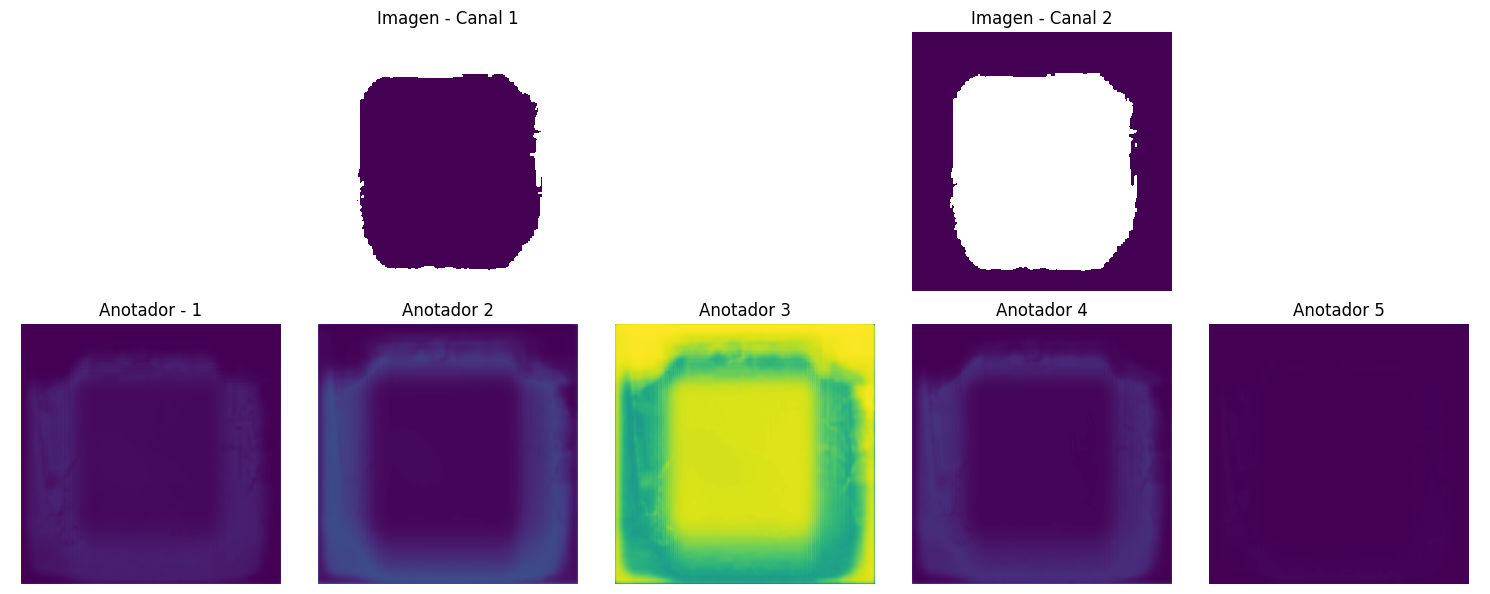

tf.Tensor(
[[0.99999994 0.99999994 1.0000001  ... 0.9999999  1.         1.        ]
 [1.         1.0000001  1.         ... 1.0000001  1.0000001  1.        ]
 [0.99999994 1.0000001  1.         ... 0.9999999  1.0000001  1.        ]
 ...
 [1.         1.         1.         ... 0.99999994 1.         1.0000001 ]
 [1.         1.         1.         ... 1.         1.         0.99999994]
 [1.         1.         0.99999994 ... 1.         1.         1.0000001 ]], shape=(256, 256), dtype=float32)
Learning Rate en la época 10: 0.0010000000474974513
Epoch 11/60
Valor mínimo: 9.750740474512862e-16 y Valor máximo: 0.11303038150072098
Valor mínimo: 5.6978528318820616e-30 y Valor máximo: 0.01673217862844467
Valor mínimo: 3.693291148465505e-07 y Valor máximo: 0.11612176150083542
Valor mínimo: 2.5219220158370637e-13 y Valor máximo: 0.02216390147805214
Valor mínimo: 3.6634253963718777e-10 y Valor máximo: 0.10744468867778778
Valor mínimo: 4.410182195214886e-19 y Valor máximo: 0.03368587791919708
Valor mínimo

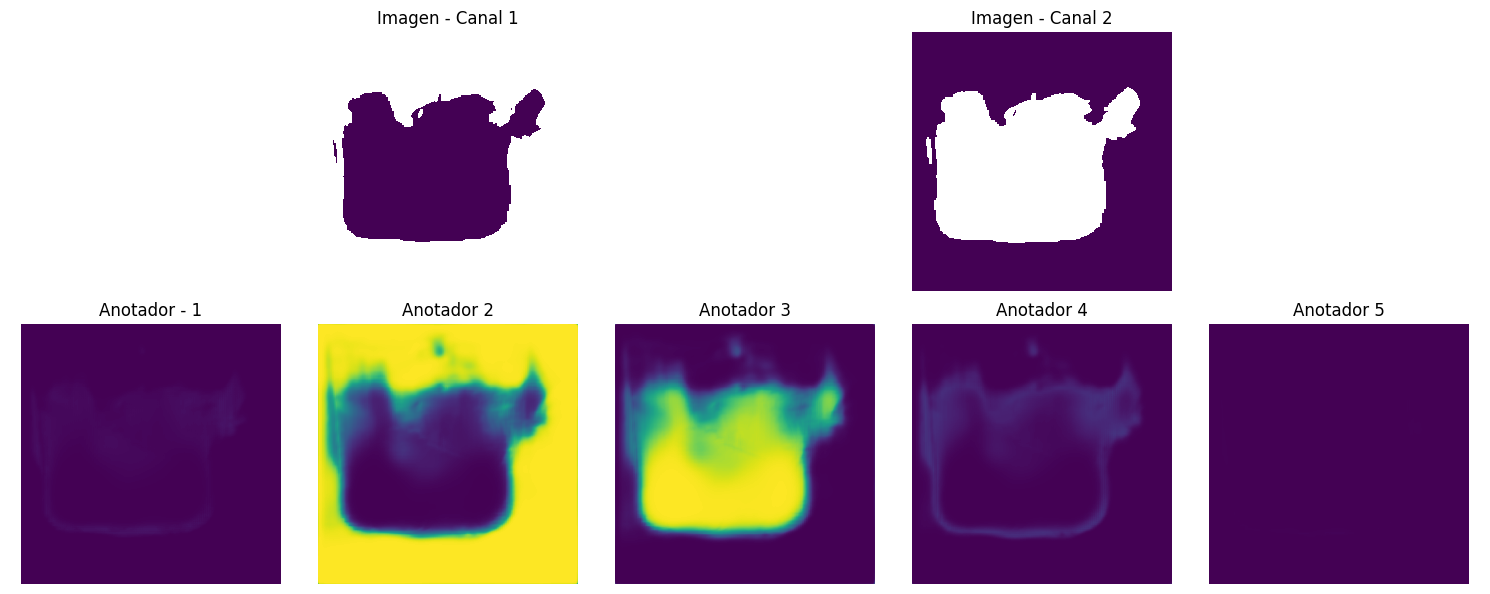

tf.Tensor(
[[0.9999999  0.9999998  0.99999994 ... 1.         0.9999999  1.        ]
 [1.         1.         1.0000001  ... 1.0000001  0.9999999  1.        ]
 [1.         1.         1.         ... 0.99999994 1.         1.        ]
 ...
 [1.         0.99999994 1.         ... 1.0000001  0.99999994 1.        ]
 [0.99999994 1.         1.0000001  ... 1.0000001  1.         1.        ]
 [0.99999994 0.99999994 1.0000001  ... 0.99999994 0.99999994 0.99999994]], shape=(256, 256), dtype=float32)
Learning Rate en la época 20: 0.0010000000474974513
Epoch 21/60
Valor mínimo: 0.0 y Valor máximo: 0.04106619581580162
Valor mínimo: 0.0 y Valor máximo: 0.003420564578846097
Valor mínimo: 4.9364466507551e-12 y Valor máximo: 0.06159551441669464
Valor mínimo: 1.2391949081520565e-16 y Valor máximo: 0.010232513770461082
Valor mínimo: 4.4165166639703567e-23 y Valor máximo: 0.06369901448488235
Valor mínimo: 1.171277779117491e-32 y Valor máximo: 0.0067931837402284145
Valor mínimo: 1.074610289499916e-18 y Valor máx

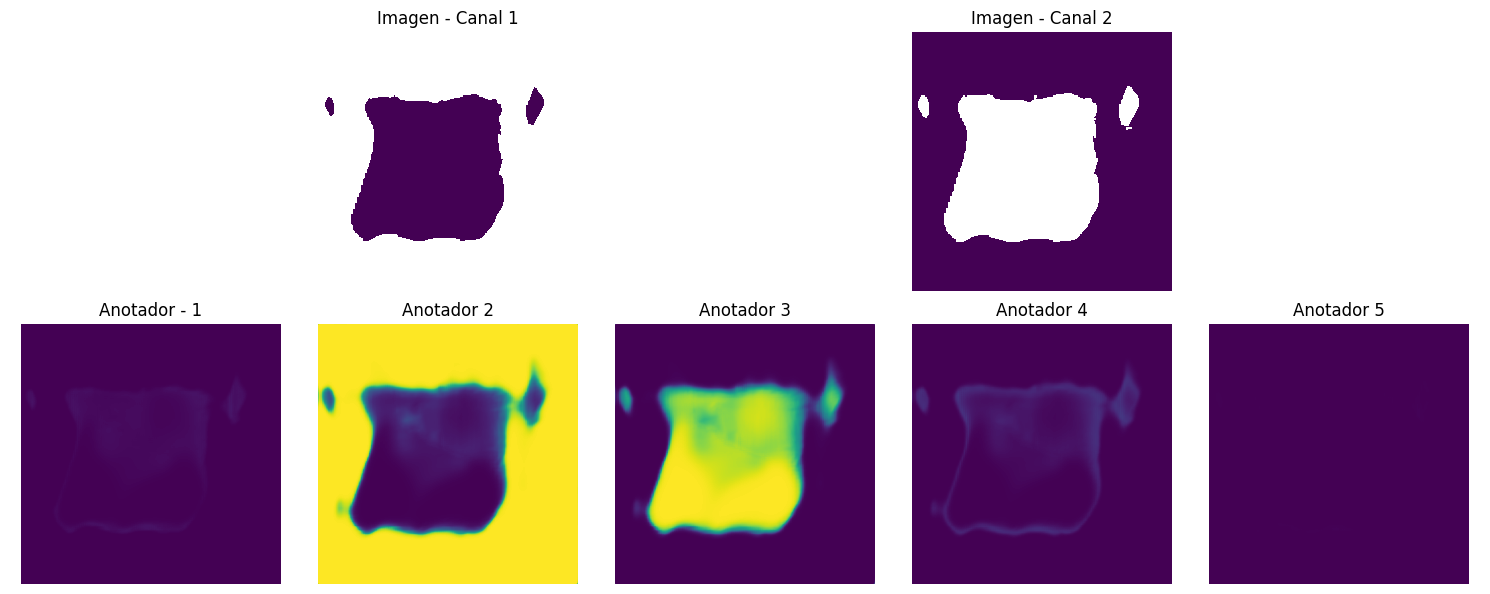

tf.Tensor(
[[1.0000001  1.         1.         ... 0.99999994 0.99999994 1.        ]
 [1.0000001  1.         0.99999994 ... 0.99999994 1.         1.        ]
 [0.99999994 1.         0.99999994 ... 1.         1.         1.        ]
 ...
 [1.         1.         0.99999994 ... 1.         1.         0.99999994]
 [0.99999994 1.         0.99999994 ... 1.         0.9999999  0.99999994]
 [1.0000001  1.0000001  1.0000001  ... 1.         0.99999994 1.        ]], shape=(256, 256), dtype=float32)
Learning Rate en la época 30: 0.0010000000474974513
Epoch 31/60
Valor mínimo: 0.0 y Valor máximo: 0.049645110964775085
Valor mínimo: 0.0 y Valor máximo: 0.006319403648376465
Valor mínimo: 3.4526617580680363e-26 y Valor máximo: 0.06865179538726807
Valor mínimo: 1.3031080235791742e-36 y Valor máximo: 0.013019612990319729
Valor mínimo: 1.5625065803763325e-33 y Valor máximo: 0.05970064923167229
Valor mínimo: 0.0 y Valor máximo: 0.006679268553853035
Valor mínimo: 4.672241333837303e-27 y Valor máximo: 0.06452080

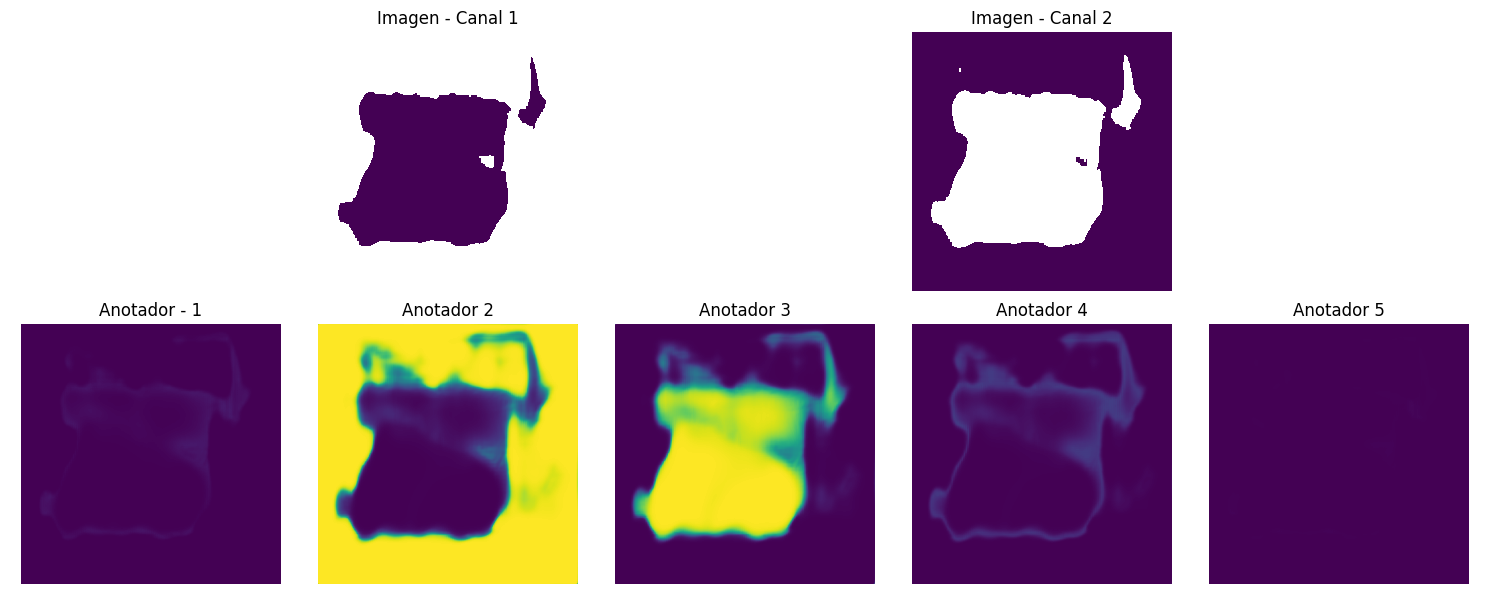

tf.Tensor(
[[0.9999999  1.         1.         ... 1.         1.         1.        ]
 [1.0000001  1.         0.99999994 ... 0.99999994 1.         0.99999994]
 [1.0000001  1.         1.         ... 1.         0.99999994 1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         0.9999999 ]
 [0.99999994 1.         0.99999994 ... 1.         1.         1.0000001 ]
 [1.0000001  1.         0.99999994 ... 1.         0.99999994 1.0000001 ]], shape=(256, 256), dtype=float32)
Learning Rate en la época 40: 0.0010000000474974513
Epoch 41/60
Valor mínimo: 0.0 y Valor máximo: 0.06211904063820839
Valor mínimo: 0.0 y Valor máximo: 0.012260973453521729
Valor mínimo: 0.0 y Valor máximo: 0.06899213790893555
Valor mínimo: 0.0 y Valor máximo: 0.01610063947737217
Valor mínimo: 0.0 y Valor máximo: 0.06542537361383438
Valor mínimo: 0.0 y Valor máximo: 0.013373110443353653
Valor mínimo: 0.0 y Valor máximo: 0.07849562913179398
Valor mínimo: 0.0 y Valor máximo: 0.02362784929573536
Valor mínimo:

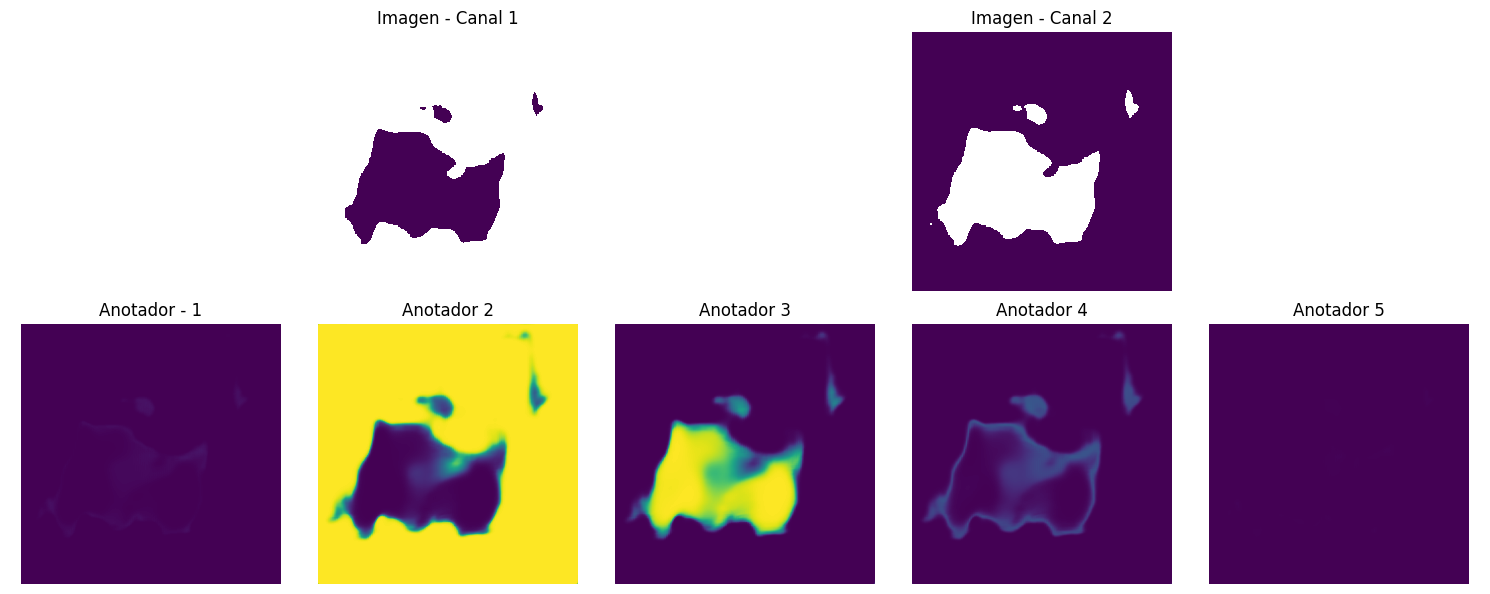

tf.Tensor(
[[1.         0.9999999  0.99999994 ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         0.99999994]
 [1.         1.         1.         ... 1.         1.         0.99999994]
 ...
 [1.         0.99999994 1.         ... 1.         1.         1.0000001 ]
 [1.         0.99999994 1.         ... 0.99999994 1.         0.99999994]
 [1.         0.99999994 1.         ... 1.         1.0000001  0.99999994]], shape=(256, 256), dtype=float32)
Learning Rate en la época 50: 0.0010000000474974513
Epoch 51/60
Valor mínimo: 0.0 y Valor máximo: 0.07426286488771439
Valor mínimo: 0.0 y Valor máximo: 0.028052320703864098
Valor mínimo: 0.0 y Valor máximo: 0.0641465112566948
Valor mínimo: 0.0 y Valor máximo: 0.016992885619401932
Valor mínimo: 0.0 y Valor máximo: 0.0620274618268013
Valor mínimo: 0.0 y Valor máximo: 0.015110149048268795
Valor mínimo: 0.0 y Valor máximo: 0.08923118561506271
Valor mínimo: 0.0 y Valor máximo: 0.040897976607084274
Valor mínimo:

In [ ]:
batch_size = 32 
optimizer = tf.keras.optimizers.Adam()
model_name = "UNET-TGCE_SS"
loss_fn = TGCE_SS()
dice_metric = DiceCoefficientMetric()
num_epochs = 60
num_img = 12


# Bucle de entrenamiento
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_loss = 0.0  # Inicializa la pérdida acumulada para esta época
    epoch_dice = 0.0  # Inicializa el coeficiente Dice acumulado para esta época
    
    # Reinicia el estado de la métrica al comienzo de cada época
    dice_metric.reset_states()
    
    for k in range(len(X_train)):
      X_train_1 = np.array(X_train[k])
      y_train_1 = np.array(y_train[k])
      # Itera sobre los datos de entrenamiento en lotes
      for i in range(0, len(X_train_1), batch_size):
          x_batch = X_train_1[i:i+batch_size]
          y_batch = y_train_1[i:i+batch_size]
          y_batch[y_batch < 0.5] = 0 # Umbralización
          y_batch[y_batch >= 0.5] = 1
        
        
          with tf.GradientTape() as tape:
              predictions = model(x_batch)
              loss, term_r, term_c = loss_fn.call(y_batch, predictions)

          # Calcula el gradiente de la pérdida con respecto a los parámetros del modelo
          gradients = tape.gradient(loss, model.trainable_variables)

          # Actualiza los pesos del modelo usando el optimizador
          optimizer.apply_gradients(zip(gradients, model.trainable_variables))

          # Acumula la pérdida de este lote
          epoch_loss += loss.numpy()  # Convertir el tensor de pérdida a un valor numérico
        
          array_ybatch = y_batch[..., :2]
          array_ybatch = array_ybatch[...,0] 
          
          # Convertir el tensor a un array de NumPy
          array_predictions = predictions.numpy()

          # Seleccionar los dos primeros canales del array
          array_predictions = array_predictions[:, :, :, :2]
          
            
          # Calcula la métrica de Dice y actualiza su estado
          dice_metric.update_state(array_ybatch, array_predictions)
            
    # Obtiene el valor de la métrica de Dice al final de cada época
    dice_result = dice_metric.result()
    # Imprime el valor de la pérdida al final de cada época
    print(f"Loss: {epoch_loss} Dice: {dice_result}")
    if (epoch + 1) % 10 == 0:
        plotter_fn(predictions,num_img)  # Graficar predicciones
        current_lr = optimizer.learning_rate.numpy()  # Obtener el learning rate actual
        print(f"Learning Rate en la época {epoch+1}: {current_lr}")
    if tf.math.is_nan(loss):
        print("====================================================================\n",term_r,"====================================================================\n",term_r,"====================================================================\n")

model.save(f'{model_name}.h5')

In [25]:
X_test_1 = X_test[0]
predictions = model.predict(X_test_1[6:7,:,:,:])

1/1 [==============================] - 1s 1s/step


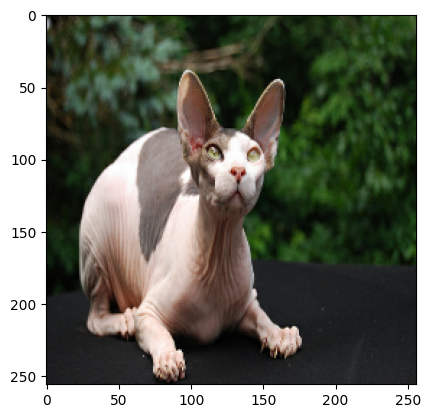

In [26]:
plt.imshow(X_test_1[6,:,:,:])

In [27]:
def plotter_y(y_test):
    # Mostrar los canales 1 y 2
    canal_1 = y_test[:, :, 0, :]  # Seleccionar el canal 1
    canal_2 = y_test[:, :, 1, :]  # Seleccionar el canal 2

    # Mostrar los canales 1 y 2 en subplots separados
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))

    for i in range(5):
        axs[0, i].imshow(canal_1[:, :, i], cmap='gray')  # Mostrar cada anotador del canal 1
        axs[0, i].set_title(f'Anotador {i+1}')
        axs[0, i].axis('off')

        axs[1, i].imshow(canal_2[:, :, i], cmap='gray')  # Mostrar cada anotador del canal 2
        axs[1, i].set_title(f'Anotador {i+1}')
        axs[1, i].axis('off')

    plt.tight_layout()
    plt.show()

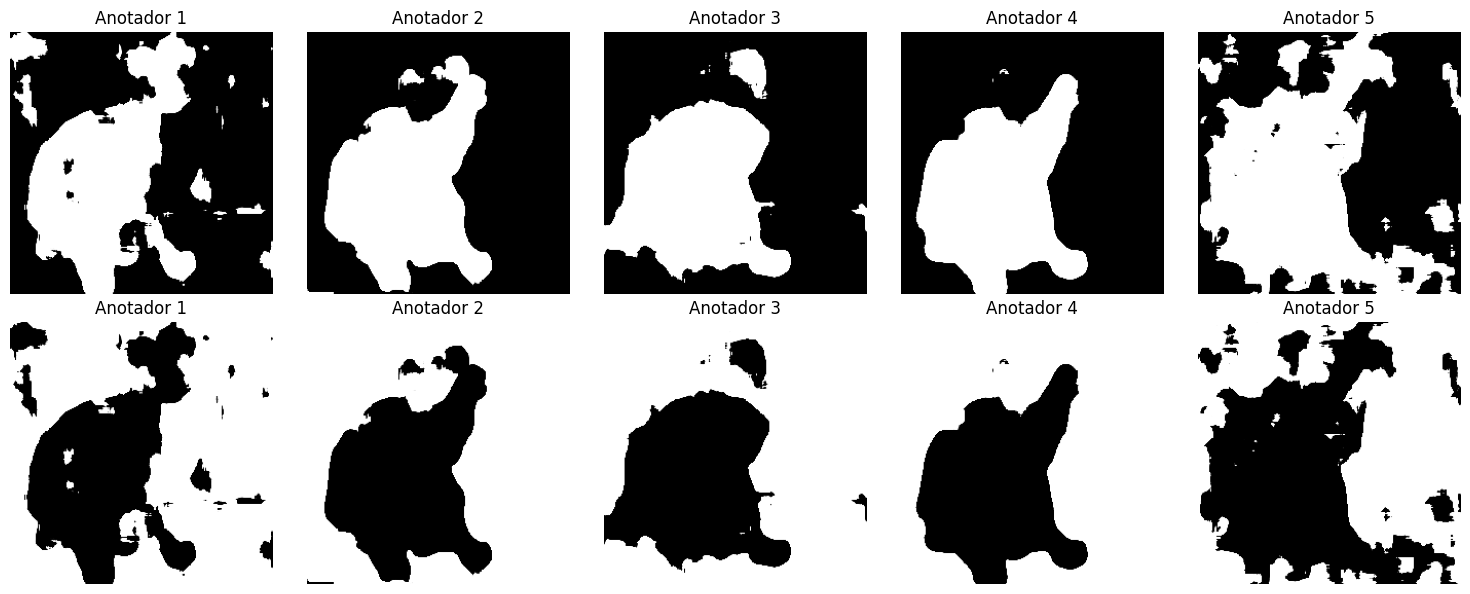

In [28]:
y_test_1 = y_test[0]
plotter_y(y_test_1[6])

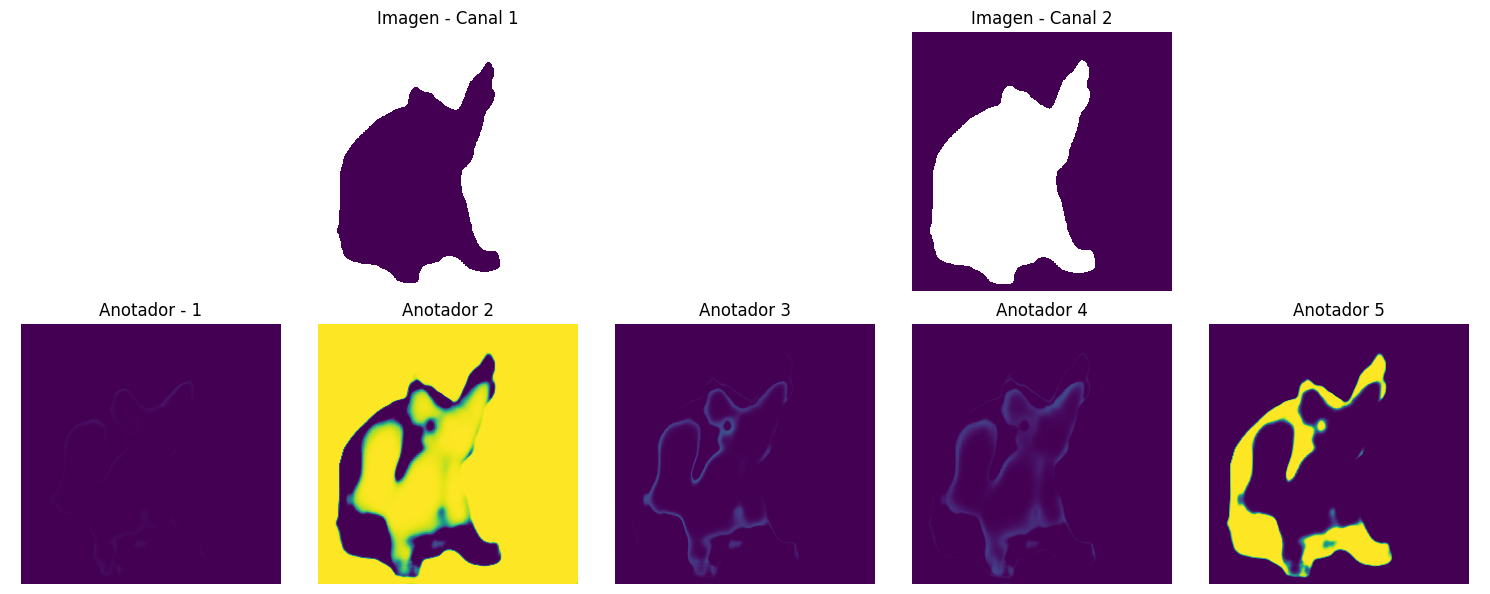

tf.Tensor(
[[1.0000001  0.9999999  0.99999994 ... 1.         1.         1.        ]
 [0.99999994 1.         0.99999994 ... 1.         1.         1.        ]
 [1.         1.0000001  1.         ... 1.         1.         1.        ]
 ...
 [1.         1.0000001  1.         ... 0.99999994 1.0000001  1.        ]
 [1.         1.0000001  0.99999994 ... 1.0000001  1.         0.9999999 ]
 [1.         0.99999994 1.         ... 1.0000001  0.9999999  1.0000001 ]], shape=(256, 256), dtype=float32)


In [29]:
plotter_fn(predictions,0)